# Colour - HDRI - Examples: Adobe DNG SDK Colour Processing

Through this example, some Canon EOS 5D Mark II *CR2* files will be white balanced using *Colour - HDRI* *Adobe DNG SDK* colour processing.

The following steps will be taken:

- Conversion of the *CR2* files to *DNG* files using [Adobe DNG Converter](http://www.adobe.com/support/downloads/detail.jsp?ftpID=5957).
- Conversion of the *DNG* files to intermediate demosaiced linear *Tiff* files using Dave Coffin's [dcraw](https://www.cybercom.net/~dcoffin/dcraw/).
- White balancing of the intermediate *Tiff* files using *Adobe DNG SDK* colour processing:
    - Reading of the *DNG* files *Exif* metadata using Phil Harvey's [ExifTool](http://www.sno.phy.queensu.ca/~phil/exiftool/).
    - Reading of the intermediate *Tiff* files pixel data using [OpenImageIO](http://openimageio.org/).
    - White balancing of the intermediate *Tiff* files.
    - Conversion of the intermediate *Tiff* files to *RGB* display colourspace.
- Display of the final resulting images.

## CR2 File Conversion to DNG and Intermediate File

In [1]:
%matplotlib inline

//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
import logging
import numpy as np
import os

import colour
from colour.plotting import *

from colour_hdri import (
    ADOBE_DNG_XYZ_ILLUMINANT,
    EXAMPLES_RESOURCES_DIRECTORY,
    camera_neutral_to_xy,
    camera_space_to_XYZ_matrix,
    convert_dng_files_to_intermediate_files,
    convert_raw_files_to_dng_files,
    filter_files,
    read_dng_files_exif_tags,
    update_exif_tags)

colour_plotting_defaults()

LOGGER = logging.getLogger()
LOGGER.setLevel(logging.DEBUG)

OETF = colour.RGB_COLOURSPACES['sRGB'].encoding_cctf

RESOURCES_DIRECTORY = os.path.join(EXAMPLES_RESOURCES_DIRECTORY,
                                   'frobisher_001')

//anaconda/envs/colour-2.7/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [3]:
RAW_FILES = filter_files(RESOURCES_DIRECTORY, ('CR2',))

DNG_FILES = convert_raw_files_to_dng_files(RAW_FILES, RESOURCES_DIRECTORY)
    
INTERMEDIATE_FILES = convert_dng_files_to_intermediate_files(
    DNG_FILES, RESOURCES_DIRECTORY, demosaicing=True)

update_exif_tags(zip(DNG_FILES, INTERMEDIATE_FILES))

1

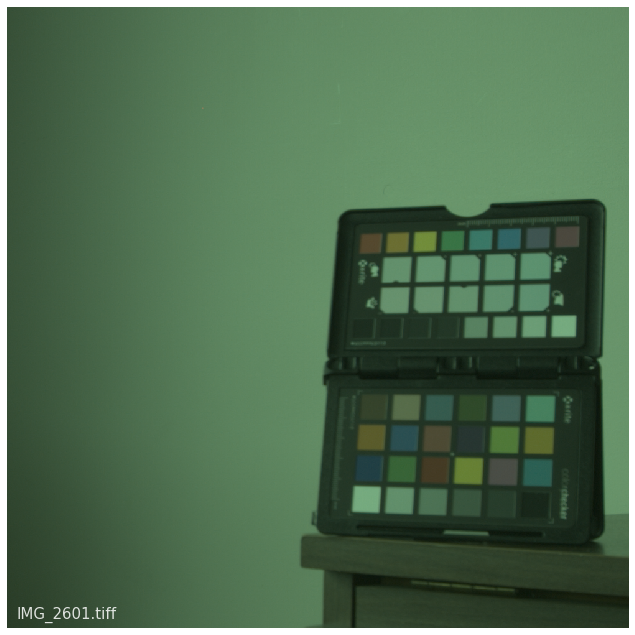

In [4]:
image_plot(OETF(colour.read_image(
            str(INTERMEDIATE_FILES[-2]))[1250:2250, 3000:4000, ...]),
           os.path.basename(INTERMEDIATE_FILES[-2]))

## Adobe DNG SDK Colour Processing

In [5]:
def process_raw_files(
        dng_files,
        output_directory):
    paths = []
    for dng_file in dng_files:
        exif_tags = read_dng_files_exif_tags((dng_file, ))[0]
        
        exif_group = exif_tags['EXIF']
        CCT_calibration_illuminant_1 = exif_group['Calibration Illuminant 1']
        CCT_calibration_illuminant_2 = exif_group['Calibration Illuminant 2']
        M_color_matrix_1 = exif_group['Color Matrix 1']
        M_color_matrix_2 = exif_group['Color Matrix 2']
        M_camera_calibration_1 = exif_group['Camera Calibration 1']
        M_camera_calibration_2 = exif_group['Camera Calibration 2']
        analog_balance = exif_group['Analog Balance']
        M_forward_matrix_1 = exif_group['Forward Matrix 1']
        M_forward_matrix_2 = exif_group['Forward Matrix 2']
        as_shot_neutral = exif_group['As Shot Neutral']
        
        LOGGER.info('"As Shot Neutral": "{0}"...'.format(as_shot_neutral))
        xy = camera_neutral_to_xy(
            as_shot_neutral,
            CCT_calibration_illuminant_1,
            CCT_calibration_illuminant_2,
            M_color_matrix_1,
            M_color_matrix_2,
            M_camera_calibration_1,
            M_camera_calibration_2,
            analog_balance)
        
        M_camera_space_to_XYZ = camera_space_to_XYZ_matrix(
            xy,
            CCT_calibration_illuminant_1,
            CCT_calibration_illuminant_2,
            M_color_matrix_1,
            M_color_matrix_2,
            M_camera_calibration_1,
            M_camera_calibration_2,
            analog_balance,
            M_forward_matrix_1,
            M_forward_matrix_2)

        LOGGER.info('"Camera Space to XYZ": "{0}"...'.format(M_camera_space_to_XYZ))
        
        path = str(dng_file.replace('dng', 'tiff'))
        image = colour.read_image(path)

        image = colour.dot_vector(M_camera_space_to_XYZ, image)
        image = colour.XYZ_to_sRGB(
            image, ADOBE_DNG_XYZ_ILLUMINANT, apply_encoding_cctf=False)

        path = os.path.join(
            output_directory,
            '{0}.{1}'.format(
                os.path.splitext(os.path.basename(path))[0],
                'exr'))
        paths.append(path)
        LOGGER.info('Writing "{0}"...'.format(path))
        colour.write_image(image, path)

    return paths


PATHS = process_raw_files(DNG_FILES, RESOURCES_DIRECTORY)

## Image Display

/Users/kelsolaar/Documents/Development/colour-science/colour/colour/models/rgb/transfer_functions/srgb.py:75: RuntimeWarning: invalid value encountered in power
  1.055 * (L ** (1 / 2.4)) - 0.055))


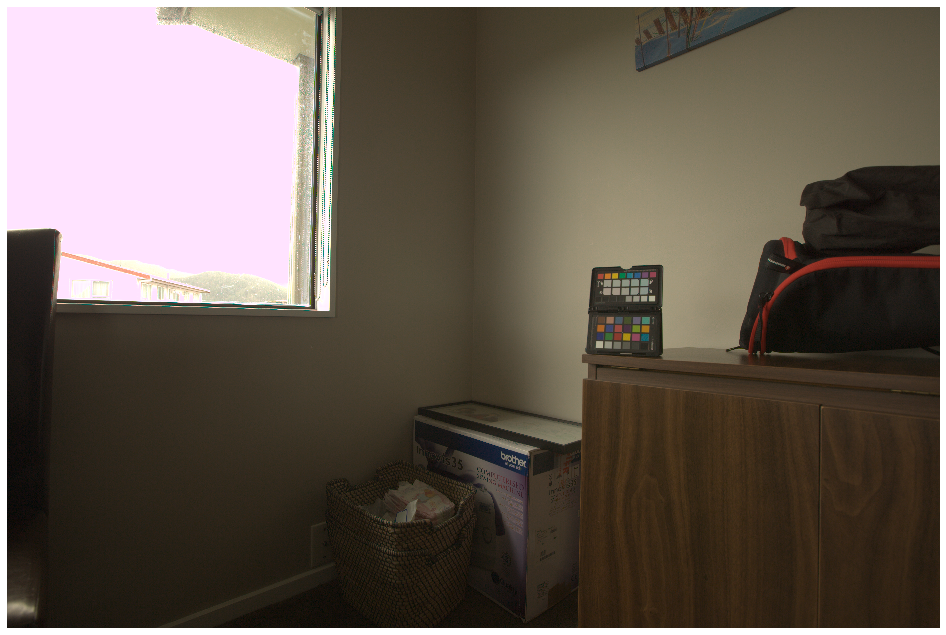

In [6]:
image_plot(OETF(colour.read_image(PATHS[-2])), '')